In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import preprocessing

import pyLDAvis
from pprint import pprint

from os import path
#from wordcloud import WordCloud, STOPWORDS 

#from PIL import Image
#from wordcloud import ImageColorGenerator
import re
#import pickle
import joblib
import spacy

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import numpy as np
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
#from textblob import TextBlob
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import warnings
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from bs4 import BeautifulSoup
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

C:\Users\Tanisha Batra\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
raw_df= pd.read_csv(r'G:/Symbi/Dataset/TelecomPOC.csv',encoding='utf-8', parse_dates=[1])
raw_df.head()
neg = raw_df[raw_df.Sentiment1=='Negative']

neg = neg.reset_index(drop=True)
text = neg.Tweet.dropna()
print(text)

#raw_df= raw_df[pd.notnull(raw_df['Tweet'])] #Delete rows where Tweet is null.

C:\Users\Tanisha Batra\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       @Vodafone won't not let me port to @JioCare f...
1            @jiocare Jio internet services depressing. 
2      @jiocare #jiofraud, no action in my complaint,...
3      @jiocare Was recharging for Jio 999 plan. When...
4      @jiocare It's been officially 10 days. Yet, no...
                             ...                        
198    I am paying about 15/-rupees per day. Your sev...
199     @JioCare @reliancejio  Why can't we make call...
200     @reliancejio  I want to port out of  @airteli...
201     @JioCare  as I have Jio Pnt I can’t make any ...
202    Jio customers are facing the problem of weak n...
Name: Tweet, Length: 203, dtype: object


In [3]:
def clean_text(RawSentence):
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
        
    txt = RawSentence.lower()
    word_tokens = word_tokenize(txt)    
    #word_tokens = word_tokenize(RawSentence)    
    
    lemma = WordNetLemmatizer()
    nlp = spacy.load('en_core_web_sm') 

    stop_words = set(stopwords.words('english'))
    stop_words.update(["amp", "rt", "cc"]) # adding twitter specific stop words
    #stop_words = stop_words - set(['no', 'not','nil'])  #removing No, not, nil from stop words     
    stop_words.update(["worst","airtelpresence","sunday","monday","tuesday","wednesday","thursday","friday","saturday","parcel",
                       "weekend","apparently","extremely","thank","worse","consolation","shouldnt","wont","arent","folks","hathway",
                     "better", "other","instead","look","yesterday","unacceptable","miss","couldnt","depress","let","good","one",
                     "thank","record","actually","frustrate","correct","ridiculous","expect","different","pathetic","terrible",
                     "bother","follow","fault","impossible","point","cover","person","ask","speak","things","earlier","mean","select","minutes",
                     "horrible","airtel","hear","current","shall","issue","warje","empty","please","check","good","give","four",
                     "literally","years","surprise","compensate","helpful","upset","excuse","attention","attach","two","three",
                     "situation","multiple","jaipur","choose","company","believe","question","anymore","awful","mumbai","month",
                      "koida","completely","finally", "waste","shock","annoy","maybe","strand","mess","finally","proper","consolation",
                      "plan","place","apology","center","plan","twitter","promise","prefer","count","maybe","shock","longer","meet","play","development",
                      "important","drop","break","reason", "wont","days","first","second","third","attempt","officially","absolutely","hello","yet","know","jio",
                      "january","february","march","april","may","june","july","august","september","october","november","december","without","thankyou",
                      "vodafone","taluk","vodafoneidea","vicustomercare","vowifi","voda","reliancejio","jiocare"])
   
    txt = re.sub(r"(@\S+)", "", txt)  # remove @
    txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
    txt = txt.translate(str.maketrans(' ', ' ', string.punctuation)) # remove punctuations 
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters from within the text (it's -> it s then we need to remove s)
    txt = re.sub(r'\^[a-zA-Z]\s+', ' ', txt) # remove all single characters from beginning of the text 
    txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
    #txt = re.sub(r'^b\s+', '', txt) # generally used when text is scrapped online. 'b' is prefixed often indicating binary text. This is not reqd for us 
    txt = [re.sub('\s+', ' ', t) for t  in txt]     # Remove new line characters
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    txt = ' '.join([i for i in txt.split(" ") if i not in stop_words])   # split() is native tokenizer in Python
    #txt = ' '.join(lemma.lemmatize(word) for word in txt.split())           # Used lemmatizer later 
    #txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stop_words ]) # stem & remove stop words
    #soup = BeautifulSoup(txt) #to scrap information from web pages....not needed here
    #txt = soup.get_text
    
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    def stem_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemma.lemmatize(item,'v'))
        return lemmatized
    
    txt = deEmojify(txt)
    tokens =[]
    
    excluded_tags = {"ADJ", "ADV", "ADP", "PROPN","CCONJ","AUX","DET","PRON"}
    for token in nlp(txt):
        if token.pos_ not in excluded_tags:
            tokens.append(token.text)
    
    lemm = stem_tokens(tokens, lemma)
    #tokens = nltk.word_tokenize(txt)
    tokens = [ch for ch in lemm if len(ch)>2] #remove words with character length below 3
    #tokens = [ch for ch in tokens if len(ch)<=15] #remove words with character length above 15 
    return tokens
    

C:\Users\Tanisha Batra\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:38: DeprecationWarning: invalid escape sequence \s
<>:38: DeprecationWarning: invalid escape sequence \s
<ipython-input-3-70120c874f52>:38: DeprecationWarning: invalid escape sequence \s
  txt = [re.sub('\s+', ' ', t) for t  in txt]     # Remove new line characters


In [4]:
#Make Bigrams and trigrams 

neg['token']=neg.Tweet.map(clean_text)
docs = neg['token']

# Add bigrams and trigrams to docs,minimum count 2 means only that appear 2 times or more. Higher threshold means fewer phrases
bigram = gensim.models.Phrases(docs, min_count=2,threshold=10)
trigram = gensim.models.Phrases(bigram[docs],threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
bigram_token = make_bigrams(docs)

C:\Users\Tanisha Batra\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Creation of Dictionary and Corpus 
#%%time
import warnings
warnings.simplefilter('ignore')

dictionary = corpora.Dictionary(bigram_token)   # Used Gensim command to create the dictionary
dictionary.filter_extremes(no_below=3)

#corpus = [dict1.doc2bow(text, allow_update=True) for text in bigram_token]    #allow_update=True was updating dictionary, so each token frequency was double
corpus = [dictionary.doc2bow(text) for text in bigram_token]
dictionary.save_as_text('G:/Symbi/Outcome/dictionary.txt')
#pickle.dump(corpus, open('gensim_corpus.pkl', 'wb'))
dictionary.save('G:/Symbi/Outcome/dictionary.gensim')
print('Number of unique Normal Dictionary tokens: %d' % len(dictionary))

# Create a dictionary representation of the documents.
#dictionary = Dictionary(docs)   # Used Gensim dictionary


Number of unique Normal Dictionary tokens: 157


In [7]:
def compute_coherence_values(dictionary, corpus, texts, start, stop):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
  
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha='auto',
                                                eta='auto', per_word_topics=True)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(coherence_values)
        
    return model_list, coherence_values

In [8]:
start=3
stop=18
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=bigram_token,
                                                        start=start, 
                                                        stop=stop)

[0.2693805102231181]
[0.2693805102231181, 0.2942764637618428]
[0.2693805102231181, 0.2942764637618428, 0.2850240734383454]
[0.2693805102231181, 0.2942764637618428, 0.2850240734383454, 0.3649999124089855]
[0.2693805102231181, 0.2942764637618428, 0.2850240734383454, 0.3649999124089855, 0.3143965410124467]
[0.2693805102231181, 0.2942764637618428, 0.2850240734383454, 0.3649999124089855, 0.3143965410124467, 0.3521736154489264]
[0.2693805102231181, 0.2942764637618428, 0.2850240734383454, 0.3649999124089855, 0.3143965410124467, 0.3521736154489264, 0.36851862309826755]
[0.2693805102231181, 0.2942764637618428, 0.2850240734383454, 0.3649999124089855, 0.3143965410124467, 0.3521736154489264, 0.36851862309826755, 0.32788547077601793]
[0.2693805102231181, 0.2942764637618428, 0.2850240734383454, 0.3649999124089855, 0.3143965410124467, 0.3521736154489264, 0.36851862309826755, 0.32788547077601793, 0.3558497310698487]
[0.2693805102231181, 0.2942764637618428, 0.2850240734383454, 0.3649999124089855, 0.314

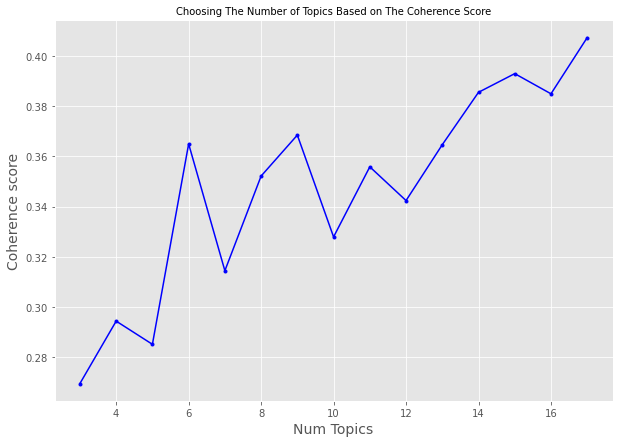

range(3, 18) [0.2693805102231181, 0.2942764637618428, 0.2850240734383454, 0.3649999124089855, 0.3143965410124467, 0.3521736154489264, 0.36851862309826755, 0.32788547077601793, 0.3558497310698487, 0.34239230835634804, 0.36467669340238246, 0.38559421947153977, 0.3930430043840387, 0.3849961377389517, 0.4074327154087257]


In [9]:
x = range(start, stop)
plt.figure(figsize=(10,7))
plt.style.use('ggplot')
plt.plot(x, coherence_values, color = "blue",marker=".")
plt.xlabel("Num Topics", size=14)
plt.ylabel("Coherence score", size=14)
plt.title('Choosing The Number of Topics Based on The Coherence Score',size=10)
plt.show()
print(x,coherence_values)

In [ ]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df['lemmas_back_to_text'])

In [10]:
%%time

# Build LDA model

# Set parameters.
num_topics = 9  #number of topics. Each topic is combination of keywords. Each keyword contributes a certain weightage to topics
chunksize = 5    #number of documents to be used in each training chunk
passes = 5       #total number of training passes through the corpus .
iterations = 25  #Maximum number of iterations through the corpus when inferring the topic distribution of a corpus. Higher value aids to reproducability because it is closer to convergence
eval_every = 1   #how often the model parameters should be updated
#alpha = document- topic density 
#eta = topic - keyword density

lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,num_topics=num_topics,
                                           id2word=dictionary,alpha='auto',eta='auto',chunksize=5,iterations=iterations,passes=5,
                                           eval_every=1)
                                           #random_state=12,

pprint(lda_model4.print_topics())
#doc_lda = lda_model1[corpus]

#lda_model4.show_topic(5)
lda_model4.save('G:/Symbi/Outcome/lda_model1.model')
lda_model4=models.LdaModel.load('G:/Symbi/Outcome/lda_model1.model')

[(0,
  '0.215*"speed" + 0.115*"use" + 0.099*"customers" + 0.095*"port" + '
  '0.086*"work" + 0.056*"jiofiber" + 0.053*"see" + 0.045*"mbps" + '
  '0.040*"switch" + 0.023*"till"'),
 (1,
  '0.179*"want_port" + 0.149*"customer" + 0.082*"thing" + 0.056*"wait" + '
  '0.053*"check" + 0.050*"deduct" + 0.047*"solve" + 0.040*"complaints" + '
  '0.037*"register" + 0.025*"respond"'),
 (2,
  '0.188*"operator" + 0.133*"try" + 0.094*"customer_care" + 0.087*"follow" + '
  '0.056*"find" + 0.055*"message" + 0.049*"everytime" + 0.046*"visit" + '
  '0.004*"refund" + 0.004*"priority"'),
 (3,
  '0.213*"take" + 0.162*"support" + 0.126*"detail" + 0.090*"village" + '
  '0.064*"router" + 0.043*"connect" + 0.038*"say" + 0.029*"stop" + '
  '0.021*"contact" + 0.019*"location"'),
 (4,
  '0.245*"area" + 0.129*"help" + 0.096*"thank" + 0.071*"pls" + 0.059*"move" + '
  '0.031*"store" + 0.030*"feel" + 0.030*"bill" + 0.027*"seem" + 0.027*"week"'),
 (5,
  '0.234*"number" + 0.070*"care" + 0.061*"months" + 0.060*"need" + '


In [11]:
# Compute Perplexity
print('\nPerplexity: ', lda_model4.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model4, texts=bigram_token, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.406232156440264

Coherence Score:  0.5562388125289766


In [13]:
# Testing model on unseen document
test_doc = '@Jiocare, my bill is not overdue, please remove the fine'
test_doc = clean_text(test_doc)
bow_test_doc = dictionary.doc2bow(test_doc)

print(lda_model4.get_document_topics(bow_test_doc))

[(0, 0.13374352), (1, 0.045921452), (2, 0.028589858), (3, 0.050820466), (4, 0.16711617), (5, 0.10812767), (6, 0.114592664), (7, 0.15809737), (8, 0.19299084)]


In [15]:
%%time

#Preparation of LSI Model and coherence computation

from gensim.models import LsiModel

lsi_model = LsiModel(corpus, num_topics=9, id2word=dictionary)
topics = lsi_model.print_topics(num_words=5)
for topic in topics:
    print(topic)
    

(0, '-0.661*"network" + -0.364*"service" + -0.250*"internet" + -0.209*"speed" + -0.185*"time"')
(1, '0.663*"service" + -0.586*"network" + 0.161*"call" + 0.149*"get" + 0.131*"customer"')
(2, '-0.706*"speed" + -0.428*"internet" + 0.307*"service" + 0.304*"network" + -0.137*"mbps"')
(3, '0.407*"speed" + -0.378*"call" + 0.302*"service" + -0.253*"internet" + -0.238*"work"')
(4, '-0.446*"internet" + 0.440*"get" + 0.335*"data" + 0.293*"call" + -0.279*"service"')
(5, '0.385*"call" + 0.362*"speed" + -0.345*"get" + -0.314*"internet" + -0.311*"use"')
(6, '0.536*"number" + -0.400*"call" + 0.344*"time" + -0.181*"internet" + -0.176*"try"')
(7, '-0.533*"number" + 0.323*"time" + -0.259*"data" + -0.234*"use" + -0.222*"connection"')
(8, '-0.633*"time" + 0.359*"problem" + 0.266*"face" + 0.181*"number" + 0.180*"help"')
Wall time: 72.1 ms


In [16]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=bigram_token, dictionary=dictionary, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi)


Coherence Score:  0.3831024873862081


In [17]:
%%time

# NMF Topic model

from gensim.test.utils import common_texts

from gensim.models import TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf

nmf = GensimNmf(
    corpus=corpus,
    num_topics=9,
    id2word=dictionary,
    chunksize=10,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    #random_state=0,
    kappa=1,
)
topics = nmf.print_topics(num_words=5)
for topic in topics:
    print(topic)
    
#nmf.show_topics()

(0, '0.129*"resolve" + 0.099*"store" + 0.086*"contact" + 0.053*"week" + 0.052*"pass"')
(1, '0.106*"call" + 0.074*"work" + 0.071*"say" + 0.071*"problem" + 0.063*"face"')
(2, '0.144*"data" + 0.121*"get" + 0.069*"use" + 0.058*"customer" + 0.053*"activate"')
(3, '0.345*"network" + 0.063*"internet" + 0.035*"face" + 0.031*"use" + 0.030*"port"')
(4, '0.133*"complaint" + 0.092*"complain" + 0.089*"time" + 0.077*"take" + 0.051*"action"')
(5, '0.325*"speed" + 0.094*"internet" + 0.061*"mbps" + 0.048*"get" + 0.025*"time"')
(6, '0.313*"number" + 0.077*"send" + 0.046*"want_port" + 0.040*"sms" + 0.034*"time"')
(7, '0.307*"service" + 0.046*"port" + 0.033*"pay" + 0.030*"customer" + 0.029*"provide"')
(8, '0.143*"try" + 0.121*"call" + 0.090*"recharge" + 0.043*"connectivity" + 0.042*"need"')
Wall time: 709 ms


In [24]:
# Compute Coherence Score
coherence_model_nmf = CoherenceModel(model=nmf, texts=bigram_token, dictionary=dictionary, coherence='c_v')
coherence_nmf_umass = CoherenceModel(model=nmf, texts=bigram_token, dictionary=dictionary, coherence='u_mass')
coherence_nmf_cv = coherence_model_nmf.get_coherence()
coherence_nmf_umass = coherence_nmf_umass.get_coherence()

print('\nCoherence Score C_V: ', coherence_nmf_cv)
print('\nCoherence Score U MASS: ', coherence_nmf_umass)


Coherence Score C_V:  0.3742144313029197

Coherence Score U MASS:  -12.230940030478564


In [26]:
%%time

from gensim.models import HdpModel
Hdp_model = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=dictionary,chunksize=10,kappa=1)
pprint(Hdp_model.print_topics())

[(0,
  '0.020*house + 0.017*ask + 0.016*area + 0.016*time + 0.016*data + '
  '0.015*choose + 0.014*reach + 0.013*stop + 0.013*installation + '
  '0.013*network'),
 (1,
  '0.031*charge + 0.023*log + 0.020*hours + 0.015*advertise + 0.015*plz + '
  '0.015*complaint + 0.014*reference + 0.014*fiber_connection + 0.014*customer '
  '+ 0.014*wfh'),
 (2,
  '0.028*months + 0.022*struggle + 0.020*work + 0.019*pls + 0.017*money + '
  '0.016*since + 0.015*action + 0.014*provide + 0.014*register + 0.014*stay'),
 (3,
  '0.028*raise + 0.023*internet + 0.019*hrs + 0.018*loot + 0.018*app + '
  '0.015*pick + 0.014*money + 0.014*give + 0.013*till + 0.013*pls'),
 (4,
  '0.019*stay + 0.019*till + 0.018*matter + 0.018*visit + 0.017*everytime + '
  '0.017*team + 0.015*seem + 0.015*attach + 0.013*request + '
  '0.013*installation'),
 (5,
  '0.022*minimum + 0.018*access + 0.018*fix + 0.017*speed + 0.017*amount + '
  '0.016*reference + 0.014*sms + 0.014*share + 0.013*week + 0.013*stop'),
 (6,
  '0.025*return_mon

In [27]:
# Compute Coherence Score
coherence_model_hdp = CoherenceModel(model=Hdp_model, texts=bigram_token, dictionary=dictionary, coherence='c_v')
coherence_hdp_cv = coherence_model_hdp.get_coherence()
print('\nCoherence Score C_V: ', coherence_hdp_cv)


Coherence Score C_V:  0.7095473028994298
